# Algorithmic complexity of CDR3s

- https://en.wikipedia.org/wiki/Algorithmic_information_theory
- http://www.scholarpedia.org/article/Algorithmic_information_theory#Science
- https://towardsdatascience.com/face-recognition-through-kolmogorov-complexity-16ac5542235b
- https://www.yacinemahdid.com/kolmogorov-complexity-to-compress-dna-sequences-using-python/
- https://en.wikipedia.org/wiki/Lempel%E2%80%93Ziv_complexity 

Insightful paper:
- https://homepages.cwi.nl/~paulv/papers/cluster.pdf
- https://citeseerx.ist.psu.edu/document?repid=rep1&type=pdf&doi=9cf7d9fe401af956f9f315c63b1775b9133bb51b

In [23]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from lempel_ziv_complexity import lempel_ziv_complexity

from NegativeClassOptimization import config
from NegativeClassOptimization import utils
from NegativeClassOptimization import preprocessing
from NegativeClassOptimization import datasets

## (Mini) Absolut

In [42]:
df = pd.read_csv(config.DATA_SLACK_1_GLOBAL, sep="\t", dtype=str)
df.head()

,Unnamed: 0,ID_slide_Variant,CDR3,Best,Slide,Energy,Structure,UID,Antigen
0,0,5319791_04a,CARSAAFITTVGWYFDVW,True,AAFITTVGWYF,-94.7,128933-BRRSLUDUUS,1ADQ_5319791_04a,1ADQ
1,1,3796836_02a,CAAAFYGRWYFDVW,True,AAFYGRWYFDV,-94.57,128933-BRRSLUSURD,1ADQ_3796836_02a,1ADQ
2,2,5098589_01a,CAAFYYGNLAWFAYW,True,AAFYYGNLAWF,-97.63,141287-DDLUSURLRR,1ADQ_5098589_01a,1ADQ
3,3,5151925_01a,CAAGWLLLFAYW,True,AAGWLLLFAYW,-95.45,124837-RRURSUUSLD,1ADQ_5151925_01a,1ADQ
4,4,879141_05a,CARYAAAGWLLLFDYW,True,AAGWLLLFDYW,-95.45,124837-RRURSUUSLD,1ADQ_879141_05a,1ADQ


In [43]:
def sample_ags(df, N):
    return df.groupby("Antigen").sample(N)

N = 30000  # 30000
df_s = sample_ags(df, N)
df_s.shape

(300000, 9)

In [44]:
# Calculate LZC
df_s["LZC"] = df_s["Slide"].apply(lempel_ziv_complexity)

In [45]:
df_s["LZC"].describe()

count    300000.000000
mean          8.690863
std           0.756681
min           5.000000
25%           8.000000
50%           9.000000
75%           9.000000
max          11.000000
Name: LZC, dtype: float64

In [46]:
def lzc_per_ag(df_s):
    return df_s.groupby("Antigen").apply(lambda x: lempel_ziv_complexity("_".join(x["Slide"])))

def shuffle(df_s):
    return df_s.sample(df_s.shape[0])


df_s = shuffle(df_s)
lzc_per_ag(df_s)

Antigen
1ADQ    60491
1FBI    60030
1H0D    60158
1NSN    60076
1OB1    59198
1WEJ    58062
2YPV    59476
3RAJ    60080
3VRL    56300
5E94    57756
dtype: int64

In [47]:
num_iter = 20
lzc_l = []
for _ in range(num_iter):
    lzc_s = lzc_per_ag(shuffle(df_s))
    lzc_l.append(lzc_s)

df_lzc = pd.DataFrame.from_records(lzc_l)
df_lzc.head()

Antigen,1ADQ,1FBI,1H0D,1NSN,1OB1,1WEJ,2YPV,3RAJ,3VRL,5E94
0,60530,60102,60157,60052,59266,58127,59525,60117,56330,57825
1,60435,60115,60201,60052,59196,58087,59515,60147,56324,57867
2,60480,60071,60131,60077,59239,58118,59543,60118,56280,57896
3,60460,60072,60186,60060,59230,58108,59518,60082,56318,57823
4,60483,60052,60202,60052,59236,58098,59515,60102,56307,57879


At 30000 samples, shuffling doesn't appear to change significantly the estimated Lempel-Ziv complexity.

Text(0.5, 0, 'Iteration')

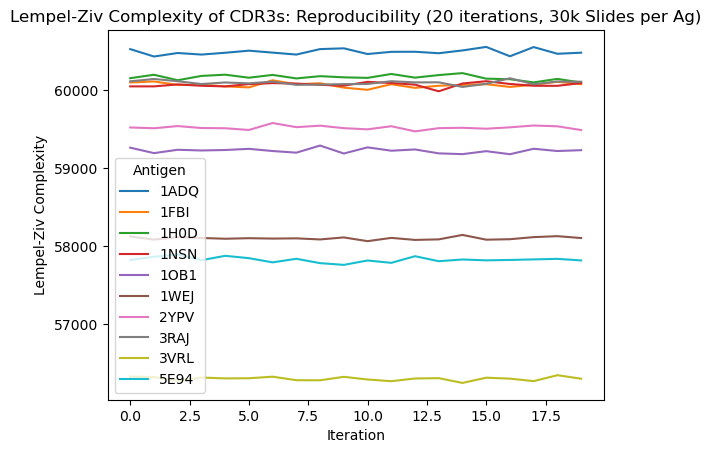

In [48]:
fig, ax = plt.subplots()
df_lzc.plot(ax=ax)
ax.set_title("Lempel-Ziv Complexity of CDR3s: Reproducibility (20 iterations, 30k Slides per Ag)")
ax.set_ylabel("Lempel-Ziv Complexity")
ax.set_xlabel("Iteration")

LZC is consistent across number of samples per antigen.

In [49]:
sampling = [1000, 5000, 10000, 20000, 30000]

lzc_l = []
for samples_per_ag in sampling:
    lzc_s = lzc_per_ag(shuffle(sample_ags(df, samples_per_ag)))
    lzc_l.append(lzc_s)

df_lzc = pd.DataFrame.from_records(lzc_l)
df_lzc.index = sampling

Text(0, 0.5, 'Lempel-Ziv Complexity')

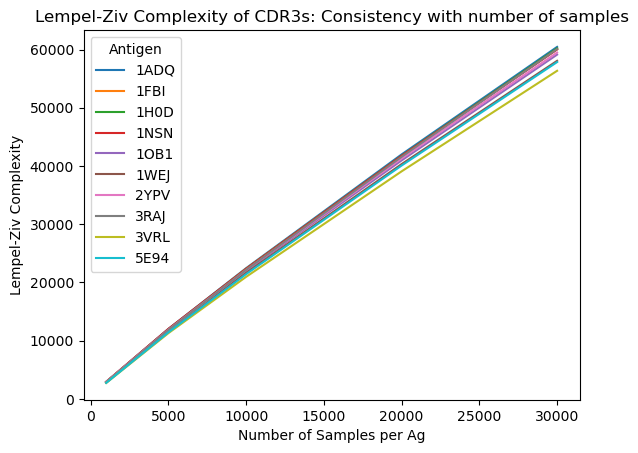

In [51]:
fig, ax = plt.subplots()
df_lzc.plot(ax=ax)
ax.set_title("Lempel-Ziv Complexity of CDR3s: Consistency with number of samples")
ax.set_xlabel("Number of Samples per Ag")
ax.set_ylabel("Lempel-Ziv Complexity")

### Comparison to CompAIRR

In [ ]:
# Todo

### Algorithmic mutual information

In [77]:
def algo_mutual_info_from_df(df_s, ag_1, ag_2, num_shuffles = 10):
    slides_1 = extract_slides(df_s, ag_1)
    slides_2 = extract_slides(df_s, ag_2)

    lzp_1u2 = estimate_lzc_union(num_shuffles, slides_1, slides_2)

    lzp_1 = estimate_lzc(num_shuffles, slides_1)
    lzp_2 = estimate_lzc(num_shuffles, slides_2)

    return int(lzp_1u2 - min(lzp_1, lzp_2))


def extract_slides(df_s, ag):
    return df_s.loc[df_s["Antigen"] == ag]["Slide"].to_list()


def estimate_lzc_union(num_shuffles, slides_1, slides_2):
    slides = slides_1 + slides_2
    # slides = list(set(slides))
    lzp_1u2 = estimate_lzc(num_shuffles, slides)
    return lzp_1u2


def estimate_lzc(num_shuffles, slides):
    lzp_1u2_samples = []
    for _ in range(num_shuffles):
        np.random.shuffle(slides)
        lzp_1u2_i = lempel_ziv_complexity("_".join(slides))
        lzp_1u2_samples.append(lzp_1u2_i)
    lzp_1u2 = np.mean(lzp_1u2_samples)
    return lzp_1u2


num_samples_per_ag = 1000
num_shuffles = 10

df_s = sample_ags(df, num_samples_per_ag)
algo_mutual_info_from_df(df_s, "1ADQ", "5E94", num_shuffles=10)

2492

Compare with CompAIRR overlaps

In [78]:
df_olaps = pd.read_csv("../data/CompAIRR/results/overlaps_d1_output.tsv", sep='\t')
df_olaps.set_index("#", inplace=True)
df_olaps.drop("OPENSET", axis=0, inplace=True)
df_olaps.drop("OPENSET", axis=1, inplace=True)
df_olaps.head()

,1ADQ,1FBI,1H0D,1NSN,1OB1,1WEJ,2YPV,3RAJ,3VRL,5E94
#,,,,,,,,,,
1ADQ,108197,2763,4036,2521,3100,3112,3872,7331,7957,4899
1FBI,2763,135298,1631,3493,8600,13111,4282,3768,4304,11708
1H0D,4036,1631,165873,3895,378,2512,30477,7965,5906,10339
1NSN,2521,3493,3895,170687,30603,6606,1524,3608,11573,15259
1OB1,3100,8600,378,30603,182923,11764,2045,2209,15462,31647


In [79]:
from itertools import combinations


num_samples_per_ag = 10000
num_shuffles = 10


df_s = sample_ags(df, num_samples_per_ag)

antigens = df_olaps.index.to_list()
records = []
for ag_1, ag_2 in combinations(antigens, 2):
    overlaps = df_olaps.loc[ag_1, ag_2]
    ami = algo_mutual_info_from_df(df_s, ag_1, ag_2, num_shuffles)
    records.append({
        "ag_1": ag_1, 
        "ag_2": ag_2, 
        "overlaps": overlaps, 
        "ami": ami,
    })

df_pairs = pd.DataFrame.from_records(records)
df_pairs.head()

,ag_1,ag_2,overlaps,ami
0,1ADQ,1FBI,2763,20274
1,1ADQ,1H0D,4036,20344
2,1ADQ,1NSN,2521,20291
3,1ADQ,1OB1,3100,20374
4,1ADQ,1WEJ,3112,20215


Text(0.5, 0, 'Overlaps (CompAIRR d=1)')

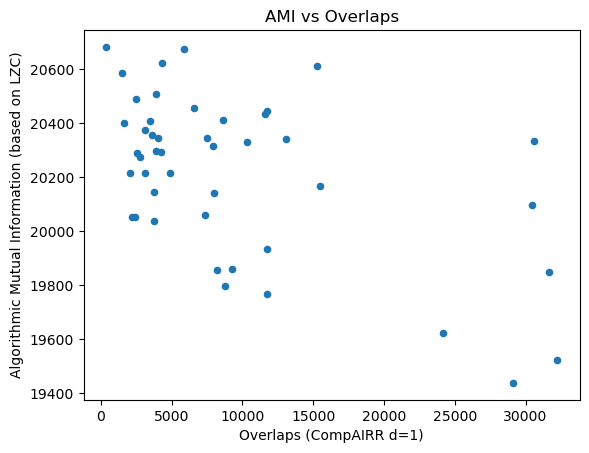

In [81]:
fig, ax = plt.subplots()
df_pairs.plot.scatter(x="overlaps", y="ami", ax=ax)
ax.set_title("AMI vs Overlaps")
ax.set_ylabel("Algorithmic Mutual Information (based on LZC)")
ax.set_xlabel("Overlaps (CompAIRR d=1)")

## (Extended) Absolut

We need to evaluate the same difference on the extended Absolut dataset to see if there is saturation behavior.

In [10]:
df = datasets.AbsolutDataset3.get_binding_matrix()
df = datasets.AbsolutDataset3.convert_to_wide_format(df)
df.head()

,1ADQ_A,1FBI_X,1FNS_A,1FSK_A,1H0D_C,1JPS_T,1KB5_AB,1NCB_N,1NSN_S,1OAZ_A,...,5JZ7_A,5KN5_C,5KTE_A,5L0Q_A,5LQB_A,5MES_A,5T5F_A,5TH9_A,5TLJ_X,5TZ2_C
Slide,,,,,,,,,,,,,,,,,,,,,
AAAFITTVVPF,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAGWLLLFDY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAIYWYFDVW,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAALLRSWFAY,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAALLRYPFAY,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [12]:
lempel_ziv_complexity("_".join(df.index))

2001299

In [15]:
(df.sum(axis=1) > 1).sum(), df.shape[0]

(729756, 1286631)

In [18]:
slide_per_ag = df.apply(sum)
slide_per_ag.sort_values(inplace=True)
slide_per_ag

In [21]:
df_g = preprocessing.convert_wide_to_global(df)

Text(0, 0.5, 'Lempel-Ziv Complexity')

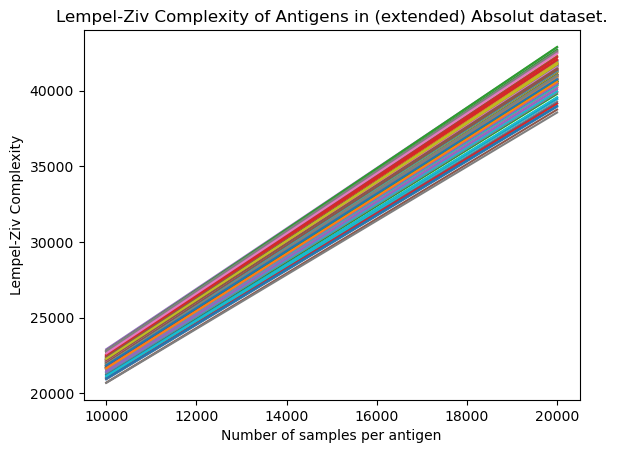

In [33]:
sampling = [10000, 20000]

lzc_l = []
for samples_per_ag in sampling:
    lzc_s = lzc_per_ag(shuffle(sample_ags(df_g, samples_per_ag)))
    lzc_l.append(lzc_s)

df_lzc = pd.DataFrame.from_records(lzc_l)
df_lzc.index = sampling

fig, ax = plt.subplots()
df_lzc.plot(ax=ax)
ax.legend().remove()
ax.set_title("Lempel-Ziv Complexity of Antigens in (extended) Absolut dataset.")
ax.set_xlabel("Number of samples per antigen")
ax.set_ylabel("Lempel-Ziv Complexity")

Text(0, 0.5, 'Lempel-Ziv Complexity')

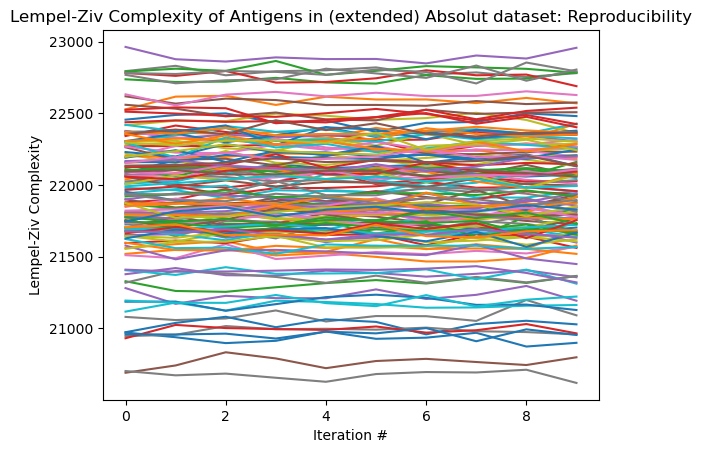

In [37]:
num_iter = 10
lzc_l = []
for _ in range(num_iter):
    lzc_s = lzc_per_ag(shuffle(sample_ags(df_g, 10000)))
    lzc_l.append(lzc_s)

df_lzc_repro = pd.DataFrame.from_records(lzc_l)

fig, ax = plt.subplots()
df_lzc_repro.plot(ax=ax)
ax.legend().remove()
ax.set_title("Lempel-Ziv Complexity of Antigens in (extended) Absolut dataset: Reproducibility")
ax.set_xlabel("Iteration #")
ax.set_ylabel("Lempel-Ziv Complexity")